##### Версия 0.1 -- Январь 2018

# Вихрь

Давайте освежим пройденное. На первых трех занятиях курса _AeroPython_ мы рассмотрели:

1. [пару источник-сток](01_Lesson01_sourceSink.ipynb) — вы научились создавать картины линий тока (`streamplot()`) и отмечать на них особые точки при помощи функции `scatter()`. Если вы выполнили домашнее задание, то убедились, что эквипотенциальные линии перпендикулярны линиям тока.

2. [пару источник-сток в набегающем потоке](02_Lesson02_sourceSinkFreestream.ipynb) — получили _овал Рэнкина_. Мы впервые уидели, что с помощью потенциальных течений можно конструировать обтекание геометрических объектов. Вы также научились определять пользовательские функции. Они заставляют Python работать на вас, и делают его еще больше похожим на обычный английский.

3. [диполь](03_Lesson03_doublet.ipynb) — картина линий тока соответсвует двумерному обтеканию кругового цилиндра. Вы столкнулись с _парадоксом д'Аламбера_ и, надеюсь, это заставило вас задуматься. Если нет, вернитесь к этому уроку и _задумайтесь_!

Сделали вы [задание](03_Lesson03_Assignment.ipynb)? Оно показывает, как с помощью *распреленных источников* смоделировать потенциальное обтекание профиля. Это уже похоже на аэродинамику!

Какой же главный результат мы желаем получить от прикладной аэродинамики? Конечно же, полететь, опираясь не на силу мускулов, а на силу разума! А для этого нужна *подъемная сила*, превосходящая вес тела, желающего взлететь.

В этом разделе нашего курса речь пойдет о подъемной силе. Вначале мы смоделируем поток в окрестности потенциального вихря. Оказывается, циркуляция вихря и подъемная сила тесно связаны.

## Что такое вихрь?

Этот вопрос сложнее, чем кажется! Простой ответ заключается в том, что вихрь это движение по круговым линиям тока. Представьте себе линии тока в виде концентрических окружностей с центром в заданной точке — при этом _совсем не обязательно_, чтобы жидкие частицы вращались вокруг своих осей.

При безвихревом циркуляционном движении азимутальная компонента скорости постоянна вдоль круговых линии тока и обратно пропорциональна радиусу, а радиальная компонента равна нулю. В полярных координатах:

\begin{equation}
u_\theta\left(r,\theta\right) = \frac{\text{constant}}{r}  \quad \text{,} \quad  u_r\left(r,\theta\right) = 0
\end{equation}

Завихренность равна нулю во всей области за исключением точки расположения вихря, в которой производная $u_\theta$ обращается в бесконечность.

Понятие циркуляции было введено на первом занятии ([Источник и сток](01_Lesson01_sourceSink.ipynb)). Воспользуемся этим определением. Вдоль любой круговой линии тока, окружающей вихрь, учитывая правило знаков, по которому вихрь, закрученный против часовой стрелки, имеет отрицательный знак, справедливо: 

\begin{equation}\Gamma = -\oint \mathbf{v}\cdot d\vec{l} = -u_\theta 2 \pi r\end{equation}

Таким образом, константа в выражении для $u_\theta$ в $(1)$ равна $\Gamma/2\pi$, и можно записать:

\begin{equation}u_\theta\left(r,\theta\right) = \frac{\Gamma}{2\pi r}\end{equation}

Функция тока можно получить, интегрируя компоненты скорости:

\begin{equation}\psi\left(r,\theta\right) = \frac{\Gamma}{2\pi}\ln r\end{equation}

В декартовых координатах функция тока записывается как

\begin{equation}\psi\left(x,y\right) = \frac{\Gamma}{4\pi}\ln\left(x^2+y^2\right)\end{equation}

а компоненты скорости:

\begin{equation}u\left(x,y\right) = \frac{\Gamma}{2\pi}\frac{y}{x^2+y^2} \qquad v\left(x,y\right) = -\frac{\Gamma}{2\pi}\frac{x}{x^2+y^2}\end{equation}

Такое циркуляционное течение является безвихревым везде, кроме центра вихря. В нем завихренность бесконечная. Интенсивность точечного вихря равна циркуляции $\Gamma$.

## Рассчитаем вихрь

Подготовительные шаги остаются прежними: импортируем любимые библиотеки и создаем сетку, в узлах которой будет рассчитываться поле скорости. 

In [1]:
import numpy
import math
from matplotlib import pyplot
# помещаем рисунки в блокнот
%matplotlib inline

In [2]:
N = 50                          # Число узлов сетки в каждом направлении
x_start, x_end = -2.0, 2.0            # границы по x
y_start, y_end = -1.0, 1.0            # границы по y
x = numpy.linspace(x_start, x_end, N)    # создаем одномерный массив x
y = numpy.linspace(y_start, y_end, N)    # создаем одномерный массив y
X, Y = numpy.meshgrid(x, y)              # создает сетку

Зададим вихрь с интенсивностью $\Gamma=5$ и поместим его в центр расчетной области:

In [3]:
gamma = 5.0                      # интенсивность вихря
x_vortex, y_vortex = 0.0, 0.0    # положение вихря

Определим две функции, 

* `get_velocity_vortex()` и
* `get_stream_function_vortex()`,

для расчета компонент скорости и функции тока на декартовой сетке по заданным интенсивности и положению вихря. В последствии мы воспользуемся этими функциями и все посчитаем. Но сначала, давайте их напишем.

In [4]:
def get_velocity_vortex(strength, xv, yv, X, Y):
    """
    Returns the velocity field generated by a vortex.
    
    Parameters
    ----------
    strength: float
        Strength of the vortex.
    xv: float
        x-coordinate of the vortex.
    yv: float
        y-coordinate of the vortex.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    u = + strength/(2*math.pi)*(Y-yv)/((X-xv)**2+(Y-yv)**2)
    v = - strength/(2*math.pi)*(X-xv)/((X-xv)**2+(Y-yv)**2)
    
    return u, v

In [5]:
def get_stream_function_vortex(strength, xv, yv, X, Y):
    """
    Returns the stream-function generated by a vortex.
    
    Parameters
    ----------
    strength: float
        Strength of the vortex.
    xv: float
        x-coordinate of the vortex.
    yv: float
        y-coordinate of the vortex.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    psi: 2D Numpy array of floats
        The stream-function.
    """
    psi = strength/(4*math.pi)*numpy.log((X-xv)**2+(Y-yv)**2)
    
    return psi

А теперь вызовем их, используя интенсивность и положение вихря, а также координаты узлов расчетной сетки в качестве параметров.

In [6]:
# рассчитываем поле скорости в узлах расчетной сетки
u_vortex, v_vortex = get_velocity_vortex(gamma, x_vortex, y_vortex, X, Y)

# рассчитываем функцию тока в узлах расчетной сетки
psi_vortex = get_stream_function_vortex(gamma, x_vortex, y_vortex, X, Y)

Теперь мы можем визуализировать линии тока для потенциального вихря и убедиться, что они выглядят как концентрические окружности с центром в месте расположения вихря, как, впрочем, и ожидалось.

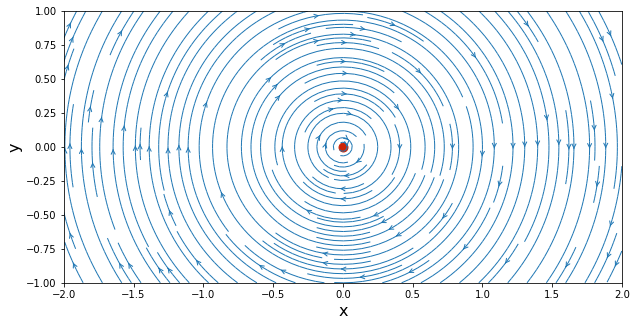

In [7]:
# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_vortex, v_vortex, density=2, linewidth=1,\
                  arrowsize=1, arrowstyle='->')
pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=80, marker='o');

## Вихрь и сток

Забавы ради, применим нашу суперспособность — сурперпозицию. Добавим к вихрю сток. Для этого воспользуемся функциями, возвращающими компоненты скорости и функцию тока для стока, и добавим полученные значения к соответствующим величинам для вихря. Получим _вихресток_.

In [8]:
strength_sink = -1.0           # интенсивность стока
x_sink, y_sink = 0.0, 0.0      # положение стока

In [9]:
def get_velocity_sink(strength, xs, ys, X, Y):
    """
    Returns the velocity field generated by a sink.
    
    Parameters
    ----------
    strength: float
        Strength of the sink.
    xs: float
        x-coordinate of the sink.
    ys: float
        y-coordinate of the sink.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    u = strength/(2*math.pi)*(X-xs)/((X-xs)**2+(Y-ys)**2)
    v = strength/(2*math.pi)*(Y-ys)/((X-xs)**2+(Y-ys)**2)
    
    return u, v

In [10]:
def get_stream_function_sink(strength, xs, ys, X, Y):
    """
    Returns the stream-function generated by a sink.
    
    Parameters
    ----------
    strength: float
        Strength of the sink.
    xs: float
        x-coordinate of the sink.
    ys: float
        y-coordinate of the sink.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    psi: 2D Numpy array of floats
        The stream-function.
    """
    psi = strength/(2*math.pi)*numpy.arctan2((Y-ys), (X-xs))
    
    return psi

In [11]:
# рассчитываем поле скорости в узлах расчетной сетки
u_sink, v_sink = get_velocity_sink(strength_sink, x_sink, y_sink, X, Y)

# рассчитываем функцию тока в узлах расчетной сетки
psi_sink = get_stream_function_sink(strength_sink, x_sink, y_sink, X, Y)

Теперь, давайте визуализируем линии тока для вихрестока, и восхитимся нашим художественным творением:

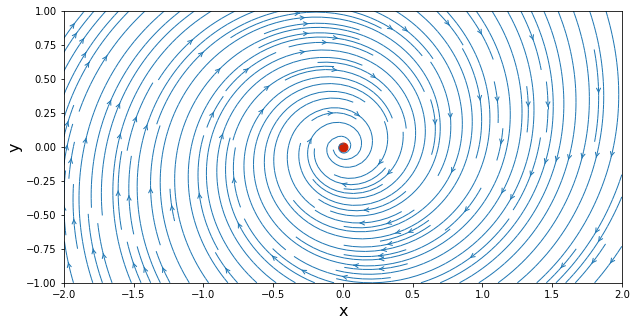

In [12]:
# суперпозиция стока и вихря
u = u_vortex + u_sink
v = v_vortex + v_sink
psi = psi_vortex + psi_sink

# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1,\
                  arrowstyle='->')
pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=80, marker='o');

Получилась отличная иллюстрация в стиле [оп-арт](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%BE). Кроме того, это неплохая модель слива воды в раковине. Но есть ли от этого какая-нибудь польза? Есть!

Сперва вам придется отбросить ходунки и — самостоятельно — смоделировать течение от [бесконечной цепчки вихрей](05_Lesson05_InfiniteRowOfVortices.ipynb). Ваше задание в следующем блокноте.

Затем мы узнаем, как связаны вихрь и подъемная сила. Вот увидите, это очень важное понятие в аэродинамике.

## Что такое "безвихревой" вихрь?

Остался непроясненным еще один важный вопрос.

Мы рассматриваем вихрь как потенциальное, а значит безвихревое течение. Это как? Конечно, если есть вихрь, есть вращение!

Глаза нас не обманывают. Такой ход мыслей довольно естественен. Но в случае с  потенциальным вихревым течением,  поток хоть и движется по круговым траекториям, элементарные объемы жидкости не вращаются вокруг собственных осей.

Классический эксперимент, демонстрируемый в этом видеоролике, поможет в понимании. Посмотрите 25 секунд после отметки 4:25 и увидите, что "измеритель завихренности" перемещается вокруг изолированного вихря, при этом не вращаясь.

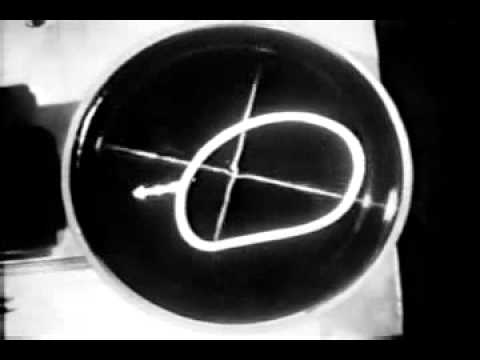

In [14]:
from IPython.display import YouTubeVideo
from datetime import timedelta

start=int(timedelta(hours=0, minutes=4, seconds=25).total_seconds())

YouTubeVideo("loCLkcYEWD4", start=start)

Помните: вихрь измеряет локальную угловую скорость каждого жидкого элемента. Если жидкие элементы движутся по кругу, но не вращаются сами по себе, то нет завихренности!

Иллюстрация из [Википедии](http://en.wikipedia.org/wiki/Vortex#Irrotational_vortices) поможет лучше понять, что происходит в изолированном вихре. Оранжевые маркеры движутся по окружностям, не меняя ориентации в пространстве.

<img src="http://upload.wikimedia.org/wikipedia/commons/0/0b/Irrotational_vortex.gif">




## Далее...

В следующем блокноте курса *AeroPython* содержится задание для самостоятельной работы ["Бесконечная цепочка вихрей"](05_Lesson05_InfiniteRowOfVortices.ipynb).

---

In [15]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()